IMPORTING THE LIBRARIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pandas as pd
from bertopic import BERTopic
# import gensim
# from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN


import random
import torch



In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [3]:
file = [
    "Gachibowli_AB.csv",
    "Jubilee_hills_AB.csv",
    "Marathahalli_AB.csv",
    "BTM_Layout_AB.csv",
    "Mumbai_AB.csv",
    "Whitefield_AB.csv",
    "Banjara_hills_AB.csv"
]

In [4]:
#Read all CSV files and concatenate them into a single DataFrame
dfs = []
for file in file:
    df = pd.read_csv(file)
    dfs.append(df)

#Combine all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)

In [5]:
combined_df.shape

(8123, 7)

In [6]:
combined_df.head()

,Name,Review_Date,Review,Owner_Response,Response_Date,Response,Review_Date.1
0,Pramod Kumar,6 months ago,"Stop eating at this place, I have visited bang...",NaN,NaN,NaN,NaN
1,abhinav deep,a year ago,Food 2/5\nService 2/5\nAmbience 2/5 …,Response from the owner,a year ago,"Dear Guest, Sorry for the inconvenience caused...",NaN
2,Vijay Nammi,a month ago,Idiotic varieties for the price they have char...,NaN,NaN,NaN,NaN
3,surya ajay,a year ago,"I am posting this live now, this is one of the...",Response from the owner,a year ago,"Dear Guest, Sorry for the inconvenience caused...",NaN
4,Sai Hithesh,6 months ago,"We are pure vegetarians, I ordered veg biryani...",NaN,NaN,NaN,NaN


In [7]:
#Remove rows where the "Review" column is empty
combined_df.dropna(subset=['Review'], inplace=True)

In [8]:
combined_df.head()

,Name,Review_Date,Review,Owner_Response,Response_Date,Response,Review_Date.1
0,Pramod Kumar,6 months ago,"Stop eating at this place, I have visited bang...",NaN,NaN,NaN,NaN
1,abhinav deep,a year ago,Food 2/5\nService 2/5\nAmbience 2/5 …,Response from the owner,a year ago,"Dear Guest, Sorry for the inconvenience caused...",NaN
2,Vijay Nammi,a month ago,Idiotic varieties for the price they have char...,NaN,NaN,NaN,NaN
3,surya ajay,a year ago,"I am posting this live now, this is one of the...",Response from the owner,a year ago,"Dear Guest, Sorry for the inconvenience caused...",NaN
4,Sai Hithesh,6 months ago,"We are pure vegetarians, I ordered veg biryani...",NaN,NaN,NaN,NaN


SAVING THE DATAFRAME TO CSV

In [9]:
combined_df.to_csv("AB_Complaints.csv")

HANDLING MISSING VALUES

In [10]:
combined_df.isnull().sum()

Name                 0
Review_Date          0
Review               0
Owner_Response    2251
Response_Date     2593
Response          2251
Review_Date.1     3863
dtype: int64

In [11]:
combined_df.drop(columns=['Owner_Response','Review_Date.1'],axis=1,inplace=True)

In [12]:
# Fill Response_Date where it is NaT (missing) and Response is not NaT (exists)
combined_df.loc[combined_df['Response_Date'].isna() & combined_df['Response'].notna(), 'Response_Date'] = combined_df['Review_Date']

In [13]:
combined_df.isnull().sum()

Name                0
Review_Date         0
Review              0
Response_Date    2251
Response         2251
dtype: int64

DATA PREPROCESSING

In [14]:
import re
import nltk
from nltk.corpus import stopwords

# Function to preprocess reviews
def preprocess_review(review):
    review = review.lower()  # Convert to lowercase
    review = re.sub(r'[^a-zA-Z\s]', '', review)  # Remove punctuation and numbers
    review = re.sub(r'\s+', ' ', review).strip()  # Remove extra whitespace

    # Tokenization
    tokens = nltk.word_tokenize(review)  # Tokenize after cleaning
    # Remove stopwords and non-alphabetic tokens
    filtered_tokens = [token for token in tokens if token.isalpha() and token not in stopwords.words('english')]
    
    # Join filtered tokens back into a string
    return " ".join(filtered_tokens)

# Assuming you have your DataFrame combined_df
combined_df['Cleaned_Review'] = combined_df['Review'].apply(preprocess_review)

# Display the updated DataFrame
combined_df[['Review', 'Cleaned_Review']].head()


,Review,Cleaned_Review
0,"Stop eating at this place, I have visited bang...",stop eating place visited bangalores nd punes ...
1,Food 2/5\nService 2/5\nAmbience 2/5 …,food service ambience
2,Idiotic varieties for the price they have char...,idiotic varieties price charged varieties boil...
3,"I am posting this live now, this is one of the...",posting live one worst places dont visit pathe...
4,"We are pure vegetarians, I ordered veg biryani...",pure vegetarians ordered veg biryani swiggy go...


In [15]:
def preprocess_name(name):
    name = name.lower()  # Convert to lowercase
    name = re.sub(r'[^a-zA-Z\s]', '', name)  # Remove non-alphabetic characters
    return name.strip()  # Remove leading/trailing whitespace

combined_df['Cleaned_Name'] = combined_df['Name'].apply(preprocess_name)
combined_df[['Name', 'Cleaned_Name']].head()

,Name,Cleaned_Name
0,Pramod Kumar,pramod kumar
1,abhinav deep,abhinav deep
2,Vijay Nammi,vijay nammi
3,surya ajay,surya ajay
4,Sai Hithesh,sai hithesh


In [16]:
combined_df.head()

,Name,Review_Date,Review,Response_Date,Response,Cleaned_Review,Cleaned_Name
0,Pramod Kumar,6 months ago,"Stop eating at this place, I have visited bang...",NaN,NaN,stop eating place visited bangalores nd punes ...,pramod kumar
1,abhinav deep,a year ago,Food 2/5\nService 2/5\nAmbience 2/5 …,a year ago,"Dear Guest, Sorry for the inconvenience caused...",food service ambience,abhinav deep
2,Vijay Nammi,a month ago,Idiotic varieties for the price they have char...,NaN,NaN,idiotic varieties price charged varieties boil...,vijay nammi
3,surya ajay,a year ago,"I am posting this live now, this is one of the...",a year ago,"Dear Guest, Sorry for the inconvenience caused...",posting live one worst places dont visit pathe...,surya ajay
4,Sai Hithesh,6 months ago,"We are pure vegetarians, I ordered veg biryani...",NaN,NaN,pure vegetarians ordered veg biryani swiggy go...,sai hithesh


TOPIC MODELING USING BERTopic

In [17]:
import numpy as np
import random
import torch
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
import joblib  # For saving the model

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Check if the 'Cleaned_Review' column exists
if 'Cleaned_Review' not in combined_df.columns:
    raise ValueError("The DataFrame does not contain a 'Cleaned_Review' column.")

# Load a pre-trained Sentence Transformer model
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

# Create a UMAP instance with fixed random state
umap_model = UMAP(n_neighbors=40, min_dist=0.0, metric='cosine', random_state=42)

# Create an HDBSCAN instance with fixed parameters
hdbscan_model = HDBSCAN(min_cluster_size=15, prediction_data=True)

# Set the desired number of topics
desired_num_topics = 60  # Modify this value as needed

# Create a BERTopic model with the specified number of topics
topic_model = BERTopic(
    embedding_model=sentence_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True,
    nr_topics=desired_num_topics,
)

# Fit the model on the processed reviews
topics, probabilities = topic_model.fit_transform(combined_df['Cleaned_Review'].tolist())

# Save the trained model
joblib.dump(topic_model, 'bertopic_model.pkl')

# Get topic information
topic_info = topic_model.get_topic_info()

# Display the number of topics found
num_topics = topic_info.shape[0]
print(f'Number of topics: {num_topics}')

# Display topics with their keywords
print("\nTopics and their keywords:")
for i in range(num_topics):
    try:
        topic_keywords = topic_model.get_topic(i)
        if topic_keywords:
            formatted_keywords = ", ".join([word for word, _ in topic_keywords])
            num_documents = topic_info[topic_info['Topic'] == i]['Count'].values[0]
            print(f"Topic {i}: {formatted_keywords} (Documents: {num_documents})")
        else:
            print(f"Topic {i} has no keywords.")
    except Exception as e:
        print(f"Error retrieving keywords for Topic {i}: {e}")

# Optionally, visualize the topics
# topic_model.visualize_topics()  # Uncomment if visualization is needed


Number of topics: 38

Topics and their keywords:
Topic 0: ok, placethere, okish, powai, better, options, , , ,  (Documents: 21)
Topic 1: reasons, god, rubbish, avoid, naramal, fuddu, eight, omg, word, words (Documents: 31)
Topic 2: kannada, song, karnataka, speak, play, songs, andre, knows, played, hindi (Documents: 27)
Topic 3: cockroach, cockroaches, found, hygiene, roaming, plate, picture, small, table, area (Documents: 25)
Topic 4: abs, experience, food, worst, disappointed, quality, time, taste, visited, bs (Documents: 181)
Topic 5: vegetarian, vegetarians, options, non, less, good, veg, place, option, food (Documents: 141)
Topic 6: branch, hills, branches, banjara, jubilee, experience, visited, whitefield, marathahalli, times (Documents: 47)
Topic 7: service, poor, satisfied, ever, pros, thanks, good, bad, bloody, raj (Documents: 34)
Topic 8: parking, valet, car, park, valets, traffic, space, vehicle, parked, road (Documents: 47)
Topic 9: ambience, food, good, service, ok, great,

In [18]:
category_labels = ['Service Issue', "Food Options", "Food Quality", "Atmosphere", "Value for Money", "Hygiene", "Others"]

topic_labels = {
    -1: ["Others"],                                      # Unrecognized topics
    0: ["Food Options", "Atmosphere"],                                 # General food references
    1: ["Others"],                                 # Reasons to avoid
    2: ["Atmosphere"],                                 # Kannada and cultural references
    3: ["Hygiene"],                                     # Cockroach issue
    4: ["Food Quality","Hygiene"],                                 # Disappointment in experience
    5: ["Food Options"],                               # Vegetarian options
    6: ["Atmosphere"],                 # Branch experience
    7: ["Service Issue"],                                # General service complaints
    8: ["Atmosphere"],                                  # Parking issues
    9: ["Food Quality", "Atmosphere","Service Issue"],                  # General ambiance
    10: ["Atmosphere"],                 # Loud music complaints
    11: ["Food Quality", "Food Options"],      # Starters and desserts
    12: ["Food Quality", "Food Options"],                           # Biryani quality
    13: ["Food Quality"],                               # General food quality
    14: ["Food Quality", "Food Options"],                              # Paneer and vegetarian options
    15: ["Food Options", "Food Quality","Value for Money"],                               # Pure vegetarian options
    16: ["Atmosphere"],                                 # Birthday celebration ambiance
    17: ["Food Options", "Atmosphere","Value for Money"],           # Buffet experience
    18: ["Atmosphere"],                                 # General family dining experience
    19: ["Food Options"],                              # Starters quality
    20: ["Food Quality", "Food Options"],                              # Prawn and fish quality
    21: ["Atmosphere", "Food Options"],                               # BBQ references
    22: ["Food Quality"],                               # Spicy food and service
    23: ["Service Issue"],                              # Average service
    24: ["Atmosphere","Service Issue"],                              # Crowding and slow service
    25: ["Food Quality"],                                   # Dirty plates and cleanliness
    26: ["Hygiene"],                                   # General cleanliness
    27: ["Atmosphere"],                                 # Weekend dining experience
    28: ["Food Quality"],                               # General taste complaints
    29: ["Food Quality"],                               # Tasteless food
    30: ["Service Issue"],                              # Staff complaints
    31: ["Service Issue", "Hygiene"],                               # Great lunch experiences
    32: ["Service Issue"],                              # Waiters and serving time
    33: ["Service Issue"],                              # Booking and reservation issues
    34: ["Service Issue", "Food Quality"],                              # Worst service experiences
    35: ["Service Issue", "Food Quality"],                               # Reduction in food quality
    36: ["Food Quality", "Service Issue"],                              # Overall food quality
    37: ["Others"],                                 # General complaints
}

topic_info['Label'] = topic_info['Topic'].map(topic_labels)
topic_info[['Topic', 'Count', 'Label']]


,Topic,Count,Label
0,-1,1668,[Others]
1,0,21,"[Food Options, Atmosphere]"
2,1,31,[Others]
3,2,27,[Atmosphere]
4,3,25,[Hygiene]
5,4,181,"[Food Quality, Hygiene]"
6,5,141,[Food Options]
7,6,47,[Atmosphere]
8,7,34,[Service Issue]
9,8,47,[Atmosphere]


ANALYZING AND VISUALIZING CATEGORY DISTRIBUTION

Label
[Atmosphere]                                     7
[Service Issue]                                  5
[Food Quality]                                   5
[Food Quality, Food Options]                     4
[Service Issue, Food Quality]                    2
[Others]                                         2
[Food Options]                                   2
[Hygiene]                                        2
[Food Quality, Atmosphere, Service Issue]        1
[Food Options, Atmosphere]                       1
[Food Quality, Hygiene]                          1
[Food Options, Food Quality, Value for Money]    1
[Food Options, Atmosphere, Value for Money]      1
[Atmosphere, Food Options]                       1
[Atmosphere, Service Issue]                      1
[Service Issue, Hygiene]                         1
[Food Quality, Service Issue]                    1
Name: count, dtype: int64


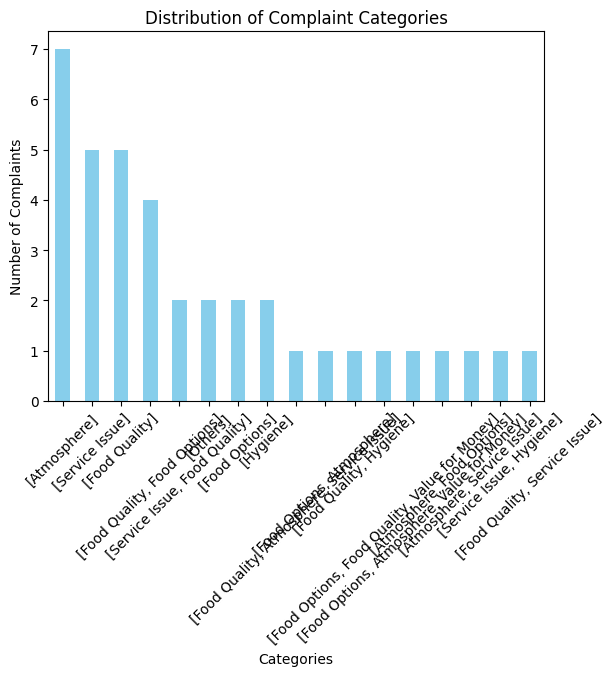

In [240]:
# Count occurrences of each label
category_counts = topic_info['Label'].value_counts()
print(category_counts)


category_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Complaint Categories')
plt.xlabel('Categories')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45)
plt.show()

MAPPING TOPICS TO CATEGORIES

In [19]:
combined_df['Topics'] = topics

combined_df['Category'] = combined_df['Topics'].map(topic_labels)

CONVERTING REVIEW DATE TO DAYS

In [20]:
def convert_to_days(review_dates):
    # Check if the input is null or empty
    if pd.isnull(review_dates) or review_dates.strip() == '':
        return -1  # Store -1 for null values
    
    # Create a dictionary for conversion
    time_in_days = {
        'year': 365,
        'month': 30,
        'week': 7,
        'day': 1
    }
    
    list1 = review_dates.split()[:2]  # Only take the first two words
    days = 0
    
    number = 1 if list1[0] == 'a' else int(list1[0])
    unit = list1[1].rstrip('s')  # Remove the plural 's'
    
    days += number * time_in_days[unit]
    
    return days


In [21]:
combined_df['Review_Days'] = combined_df['Review_Date'].map(convert_to_days)

In [22]:
combined_df.isnull().sum()

Name                 0
Review_Date          0
Review               0
Response_Date     2251
Response          2251
Cleaned_Review       0
Cleaned_Name         0
Topics               0
Category             0
Review_Days          0
dtype: int64

IDENTIFYING UNIQUE AND REPEAT CUSTOMERS

In [23]:
#Finding Unique Customers
dictionary = combined_df['Cleaned_Name'].value_counts()
dictionary = dictionary.to_dict()

In [24]:
combined_df['Unique_Customer'] = combined_df['Cleaned_Name'].apply(lambda x: 'First_Time' if dictionary[x] == 1 else 'Repeat')

In [25]:
combined_df.isnull().sum()

Name                  0
Review_Date           0
Review                0
Response_Date      2251
Response           2251
Cleaned_Review        0
Cleaned_Name          0
Topics                0
Category              0
Review_Days           0
Unique_Customer       0
dtype: int64

SEVERITY CLASSIFICATION USING SENTIMENT ANALYSIS

In [26]:
from transformers import pipeline

# Load a sentiment analysis pipeline
sentiment_pipeline = pipeline('sentiment-analysis')

# Analyze sentiment
sentiments = sentiment_pipeline(combined_df['Cleaned_Review'].tolist())
list (sentiments)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'NEGATIVE', 'score': 0.9993200302124023},
 {'label': 'POSITIVE', 'score': 0.9989683628082275},
 {'label': 'NEGATIVE', 'score': 0.999792754650116},
 {'label': 'NEGATIVE', 'score': 0.9995315074920654},
 {'label': 'NEGATIVE', 'score': 0.9987488985061646},
 {'label': 'NEGATIVE', 'score': 0.9986369013786316},
 {'label': 'NEGATIVE', 'score': 0.9904683232307434},
 {'label': 'NEGATIVE', 'score': 0.9980587363243103},
 {'label': 'NEGATIVE', 'score': 0.9968034029006958},
 {'label': 'NEGATIVE', 'score': 0.9990241527557373},
 {'label': 'NEGATIVE', 'score': 0.6061050891876221},
 {'label': 'NEGATIVE', 'score': 0.9996324777603149},
 {'label': 'NEGATIVE', 'score': 0.9994240999221802},
 {'label': 'NEGATIVE', 'score': 0.9955106973648071},
 {'label': 'NEGATIVE', 'score': 0.9995400905609131},
 {'label': 'NEGATIVE', 'score': 0.9991546869277954},
 {'label': 'NEGATIVE', 'score': 0.9974332451820374},
 {'label': 'NEGATIVE', 'score': 0.9997349381446838},
 {'label': 'NEGATIVE', 'score': 0.9957938194274

SENTIMENT ANALYSIS USING TEXTBLOB

In [27]:
from textblob import TextBlob

In [28]:
# Function to calculate sentiment using TextBlob
def get_sentiment(review):
    analysis = TextBlob(review)
    return analysis.sentiment.polarity  # Return polarity score

# Apply the function to the 'Review' column
combined_df['Sentiment_Score'] = combined_df['Cleaned_Review'].apply(get_sentiment)

In [29]:
def get_severity(sentiment_score):
	if sentiment_score > 0.1:
		return "Low"
	elif sentiment_score >= -0.1:
		return "Medium"
	else:
		return "High"



# Apply the function to the sentiment scores
combined_df['Severity'] = combined_df['Cleaned_Review'].apply(lambda review: get_severity(TextBlob(review).sentiment.polarity))

# Display the updated DataFrame
combined_df['Severity'].value_counts()

Severity
Low       2120
High      1079
Medium    1006
Name: count, dtype: int64

In [30]:
combined_df.isnull().sum()

Name                  0
Review_Date           0
Review                0
Response_Date      2251
Response           2251
Cleaned_Review        0
Cleaned_Name          0
Topics                0
Category              0
Review_Days           0
Unique_Customer       0
Sentiment_Score       0
Severity              0
dtype: int64

In [31]:
list1 = list(combined_df['Cleaned_Review'])

In [254]:
# # Assuming 'sentiment_scores' is a list of sentiment scores
# plt.hist(list1, bins=20, edgecolor='black')
# plt.title("Distribution of Sentiment Scores")
# plt.xlabel("Sentiment Score")
# plt.ylabel("Frequency")
# plt.show()

IDENTIFYING FREQUENCY OF COMPLAINT TYPE USING TF-IDF AND COSINE SIMILARITY

In [32]:
# creating TfidfVectorizer

vectorizer = TfidfVectorizer()

x = vectorizer.fit_transform(combined_df["Cleaned_Review"])

In [33]:
threshold = 0.7

In [34]:
cosine_sim = cosine_similarity(x, x)

In [35]:
combined_df['Is_Repeated'] = False

# Step 5: Loop through the similarity matrix and mark similar reviews
for i in range(len(cosine_sim)):
    for j in range(i + 1, len(cosine_sim)):
        if cosine_sim[i][j] > threshold:
            combined_df.loc[j, 'Is_Repeated'] = True  # Mark the repeated review

In [36]:
combined_df['Is_Repeated'].value_counts()

Is_Repeated
False    4140
True      113
Name: count, dtype: int64

In [37]:
combined_df.isnull().sum()

Name                 48
Review_Date          48
Review               48
Response_Date      2299
Response           2299
Cleaned_Review       48
Cleaned_Name         48
Topics               48
Category             48
Review_Days          48
Unique_Customer      48
Sentiment_Score      48
Severity             48
Is_Repeated           0
dtype: int64

In [38]:
combined_df['Frequency_Of_Complaint_Type'] = combined_df['Is_Repeated'].apply(lambda x: 'Repeated' if x == True else 'Unique')

In [39]:
combined_df.isnull().sum()

Name                             48
Review_Date                      48
Review                           48
Response_Date                  2299
Response                       2299
Cleaned_Review                   48
Cleaned_Name                     48
Topics                           48
Category                         48
Review_Days                      48
Unique_Customer                  48
Sentiment_Score                  48
Severity                         48
Is_Repeated                       0
Frequency_Of_Complaint_Type       0
dtype: int64

COMPLAINT URGENCY

In [40]:
combined_df['Urgency'] = combined_df['Sentiment_Score'].apply(lambda x: 'Urgent' if x < -0.1 else 'Non-Urgent') 

In [41]:
combined_df['Urgency'].value_counts()

Urgency
Non-Urgent    3174
Urgent        1079
Name: count, dtype: int64

In [42]:
combined_df.isnull().sum()

Name                             48
Review_Date                      48
Review                           48
Response_Date                  2299
Response                       2299
Cleaned_Review                   48
Cleaned_Name                     48
Topics                           48
Category                         48
Review_Days                      48
Unique_Customer                  48
Sentiment_Score                  48
Severity                         48
Is_Repeated                       0
Frequency_Of_Complaint_Type       0
Urgency                           0
dtype: int64

ACKNOWLEDGEMENT TIME (RESPONSE TIME)

In [43]:
combined_df['Response_Days'] = combined_df['Response_Date'].map(convert_to_days)

In [44]:
combined_df.isnull().sum()

Name                             48
Review_Date                      48
Review                           48
Response_Date                  2299
Response                       2299
Cleaned_Review                   48
Cleaned_Name                     48
Topics                           48
Category                         48
Review_Days                      48
Unique_Customer                  48
Sentiment_Score                  48
Severity                         48
Is_Repeated                       0
Frequency_Of_Complaint_Type       0
Urgency                           0
Response_Days                     0
dtype: int64

CALCULATING CUSTOMER SATISFACTION BASED ON RESPONSE AND REVIEW DAYS

In [45]:
# Customer Satisfaction Function based on Response_Days and Review_Days
def calculate_satisfaction(response_days, review_days):
    if response_days == -1:  # No response case
        return 'No Response'
    
    days_difference = response_days - review_days  # Calculate difference internally
    
    if days_difference <= 0:
        return 'High Satisfaction'  # Response was immediate or before the review
    elif 1 <= days_difference <= 3:
        return 'Medium Satisfaction'  # Response within a few days
    else:
        return 'Low Satisfaction'  # Delayed response

# Apply the customer satisfaction calculation
combined_df['Customer_Satisfaction'] = combined_df.apply(
    lambda row: calculate_satisfaction(row['Response_Days'], row['Review_Days']),
    axis=1
)

# Display the DataFrame with customer satisfaction
combined_df[['Review_Date', 'Response_Days', 'Review_Days', 'Response_Days', 'Customer_Satisfaction']]

,Review_Date,Response_Days,Review_Days,Response_Days,Customer_Satisfaction
0,6 months ago,-1,180.0,-1,No Response
1,a year ago,365,365.0,365,High Satisfaction
2,a month ago,-1,30.0,-1,No Response
3,a year ago,365,365.0,365,High Satisfaction
4,6 months ago,-1,180.0,-1,No Response
...,...,...,...,...,...
3833,NaN,-1,NaN,-1,No Response
3850,NaN,-1,NaN,-1,No Response
3283,NaN,-1,NaN,-1,No Response
3856,NaN,-1,NaN,-1,No Response


In [46]:
combined_df.head()

,Name,Review_Date,Review,Response_Date,Response,Cleaned_Review,Cleaned_Name,Topics,Category,Review_Days,Unique_Customer,Sentiment_Score,Severity,Is_Repeated,Frequency_Of_Complaint_Type,Urgency,Response_Days,Customer_Satisfaction
0,Pramod Kumar,6 months ago,"Stop eating at this place, I have visited bang...",NaN,NaN,stop eating place visited bangalores nd punes ...,pramod kumar,-1.0,[Others],180.0,Repeat,-0.350000,High,False,Unique,Urgent,-1,No Response
1,abhinav deep,a year ago,Food 2/5\nService 2/5\nAmbience 2/5 …,a year ago,"Dear Guest, Sorry for the inconvenience caused...",food service ambience,abhinav deep,9.0,"[Food Quality, Atmosphere, Service Issue]",365.0,First_Time,0.000000,Medium,False,Unique,Non-Urgent,365,High Satisfaction
2,Vijay Nammi,a month ago,Idiotic varieties for the price they have char...,NaN,NaN,idiotic varieties price charged varieties boil...,vijay nammi,-1.0,[Others],30.0,First_Time,-0.388889,High,False,Unique,Urgent,-1,No Response
3,surya ajay,a year ago,"I am posting this live now, this is one of the...",a year ago,"Dear Guest, Sorry for the inconvenience caused...",posting live one worst places dont visit pathe...,surya ajay,34.0,"[Service Issue, Food Quality]",365.0,First_Time,-0.772727,High,False,Unique,Urgent,365,High Satisfaction
4,Sai Hithesh,6 months ago,"We are pure vegetarians, I ordered veg biryani...",NaN,NaN,pure vegetarians ordered veg biryani swiggy go...,sai hithesh,5.0,[Food Options],180.0,First_Time,0.214286,Low,False,Unique,Non-Urgent,-1,No Response


In [47]:
combined_df.isnull().sum()

Name                             48
Review_Date                      48
Review                           48
Response_Date                  2299
Response                       2299
Cleaned_Review                   48
Cleaned_Name                     48
Topics                           48
Category                         48
Review_Days                      48
Unique_Customer                  48
Sentiment_Score                  48
Severity                         48
Is_Repeated                       0
Frequency_Of_Complaint_Type       0
Urgency                           0
Response_Days                     0
Customer_Satisfaction             0
dtype: int64

In [48]:
# Display rows with any null values in the DataFrame
null_rows = combined_df[combined_df.isnull().any(axis=1)]

# Show the DataFrame with null rows
null_rows


,Name,Review_Date,Review,Response_Date,Response,Cleaned_Review,Cleaned_Name,Topics,Category,Review_Days,Unique_Customer,Sentiment_Score,Severity,Is_Repeated,Frequency_Of_Complaint_Type,Urgency,Response_Days,Customer_Satisfaction
0,Pramod Kumar,6 months ago,"Stop eating at this place, I have visited bang...",NaN,NaN,stop eating place visited bangalores nd punes ...,pramod kumar,-1.0,[Others],180.0,Repeat,-0.350000,High,False,Unique,Urgent,-1,No Response
2,Vijay Nammi,a month ago,Idiotic varieties for the price they have char...,NaN,NaN,idiotic varieties price charged varieties boil...,vijay nammi,-1.0,[Others],30.0,First_Time,-0.388889,High,False,Unique,Urgent,-1,No Response
4,Sai Hithesh,6 months ago,"We are pure vegetarians, I ordered veg biryani...",NaN,NaN,pure vegetarians ordered veg biryani swiggy go...,sai hithesh,5.0,[Food Options],180.0,First_Time,0.214286,Low,False,Unique,Non-Urgent,-1,No Response
5,armaan akhter,a week ago,waste management they gave us time 3.30 PM @Ga...,NaN,NaN,waste management gave us time pm gachibowli br...,armaan akhter,34.0,"[Service Issue, Food Quality]",7.0,First_Time,-0.375000,High,False,Unique,Urgent,-1,No Response
8,Keshav Akkineni,3 months ago,"The food was not good at all. The plates, spoo...",NaN,NaN,food good plates spoons bowls cleaned properly...,keshav akkineni,-1.0,[Others],90.0,First_Time,-0.083333,Medium,False,Unique,Non-Urgent,-1,No Response
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Repeated,Non-Urgent,-1,No Response
3850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Repeated,Non-Urgent,-1,No Response
3283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Repeated,Non-Urgent,-1,No Response
3856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,Repeated,Non-Urgent,-1,No Response


DELETING NULL ROWS

In [49]:
# Set the threshold for non-null values
# For example, keep rows with at least 5 non-null values
threshold = 6

# Drop rows with less than the specified threshold of non-null values
combined_df = combined_df.dropna(thresh=threshold)

# Check the number of null values after deletion
print(combined_df.isnull().sum())


Name                              0
Review_Date                       0
Review                            0
Response_Date                  2251
Response                       2251
Cleaned_Review                    0
Cleaned_Name                      0
Topics                            0
Category                          0
Review_Days                       0
Unique_Customer                   0
Sentiment_Score                   0
Severity                          0
Is_Repeated                       0
Frequency_Of_Complaint_Type       0
Urgency                           0
Response_Days                     0
Customer_Satisfaction             0
dtype: int64


In [50]:
combined_df.shape

(4205, 18)

In [51]:

data = combined_df[['Review','Cleaned_Review', 'Cleaned_Name', 'Topics', 'Category', 
                      'Severity', 'Is_Repeated','Unique_Customer', 'Sentiment_Score','Frequency_Of_Complaint_Type', 
                      'Urgency', 'Customer_Satisfaction', 'Review_Days', 
                      'Response_Days']].copy()

# Optionally, reset the index of the new DataFrame
data.reset_index(drop=True, inplace=True)

# Display the new DataFrame
data.head()


,Review,Cleaned_Review,Cleaned_Name,Topics,Category,Severity,Is_Repeated,Unique_Customer,Sentiment_Score,Frequency_Of_Complaint_Type,Urgency,Customer_Satisfaction,Review_Days,Response_Days
0,"Stop eating at this place, I have visited bang...",stop eating place visited bangalores nd punes ...,pramod kumar,-1.0,[Others],High,False,Repeat,-0.350000,Unique,Urgent,No Response,180.0,-1
1,Food 2/5\nService 2/5\nAmbience 2/5 …,food service ambience,abhinav deep,9.0,"[Food Quality, Atmosphere, Service Issue]",Medium,False,First_Time,0.000000,Unique,Non-Urgent,High Satisfaction,365.0,365
2,Idiotic varieties for the price they have char...,idiotic varieties price charged varieties boil...,vijay nammi,-1.0,[Others],High,False,First_Time,-0.388889,Unique,Urgent,No Response,30.0,-1
3,"I am posting this live now, this is one of the...",posting live one worst places dont visit pathe...,surya ajay,34.0,"[Service Issue, Food Quality]",High,False,First_Time,-0.772727,Unique,Urgent,High Satisfaction,365.0,365
4,"We are pure vegetarians, I ordered veg biryani...",pure vegetarians ordered veg biryani swiggy go...,sai hithesh,5.0,[Food Options],Low,False,First_Time,0.214286,Unique,Non-Urgent,No Response,180.0,-1


In [52]:
def add_category_features(df, categories):
    """
    Adds binary columns for each specified category in the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The original DataFrame with a 'Category' column containing lists of categories.
    - categories (list of str): List of categories to be added as new columns.
    
    Returns:
    - pd.DataFrame: Updated DataFrame with new binary category columns.
    """
    # Loop through each category and create a new column in the DataFrame
    for category in categories:
        # Check if each category is present in the list of categories for each review
        df[category] = df['Category'].apply(lambda x: 1 if isinstance(x, list) and category in x else 0)
    
    return df

# List of categories to be checked and added as columns
categories_to_add = ['Service Issue', "Food Options", "Food Quality", "Atmosphere", "Value for Money", "Hygiene", "Others"]

# Apply the function to add the new features
data = add_category_features(data, categories_to_add)

# Display the updated DataFrame
data


,Review,Cleaned_Review,Cleaned_Name,Topics,Category,Severity,Is_Repeated,Unique_Customer,Sentiment_Score,Frequency_Of_Complaint_Type,...,Customer_Satisfaction,Review_Days,Response_Days,Service Issue,Food Options,Food Quality,Atmosphere,Value for Money,Hygiene,Others
0,"Stop eating at this place, I have visited bang...",stop eating place visited bangalores nd punes ...,pramod kumar,-1.0,[Others],High,False,Repeat,-0.350000,Unique,...,No Response,180.0,-1,0,0,0,0,0,0,1
1,Food 2/5\nService 2/5\nAmbience 2/5 …,food service ambience,abhinav deep,9.0,"[Food Quality, Atmosphere, Service Issue]",Medium,False,First_Time,0.000000,Unique,...,High Satisfaction,365.0,365,1,0,1,1,0,0,0
2,Idiotic varieties for the price they have char...,idiotic varieties price charged varieties boil...,vijay nammi,-1.0,[Others],High,False,First_Time,-0.388889,Unique,...,No Response,30.0,-1,0,0,0,0,0,0,1
3,"I am posting this live now, this is one of the...",posting live one worst places dont visit pathe...,surya ajay,34.0,"[Service Issue, Food Quality]",High,False,First_Time,-0.772727,Unique,...,High Satisfaction,365.0,365,1,0,1,0,0,0,0
4,"We are pure vegetarians, I ordered veg biryani...",pure vegetarians ordered veg biryani swiggy go...,sai hithesh,5.0,[Food Options],Low,False,First_Time,0.214286,Unique,...,No Response,180.0,-1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4200,Place where food lovers can enjoy their food a...,place food lovers enjoy food apart dishes rest...,hemanth kumar pallapu,31.0,"[Service Issue, Hygiene]",Low,False,First_Time,0.391667,Unique,...,No Response,1825.0,-1,1,0,0,0,0,1,0
4201,"Good place to visit with friends and family, t...",good place visit friends family customised foo...,abhinay maredugonda,16.0,[Atmosphere],Low,False,First_Time,0.409524,Unique,...,No Response,1460.0,-1,0,0,0,1,0,0,0
4202,"The food is very good, service is also good. B...",food good service also good compare service co...,devesh gupta,35.0,"[Service Issue, Food Quality]",Low,False,First_Time,0.550000,Unique,...,No Response,2555.0,-1,1,0,1,0,0,0,0
4203,Nice place to hangout with a small team of upt...,nice place hangout small team upto members goo...,raja roy,18.0,[Atmosphere],Low,False,First_Time,0.437500,Unique,...,No Response,365.0,-1,0,0,0,1,0,0,0


In [286]:
# from sklearn.preprocessing import LabelEncoder

# # Assuming the relevant columns are in new_df
# # Columns: 'Severity', 'Urgency', 'Frequency_of_Complaint_Type', 'Unique_Customer'

# # Initialize LabelEncoder
# le = LabelEncoder()

# # Create new numerical features
# data['Severity_Label'] = le.fit_transform(data['Severity'])  # High, Medium, Low
# data['Urgency_Label'] = le.fit_transform(data['Urgency'])  # Urgent, Non-Urgent
# data['Frequency_Label'] = le.fit_transform(data['Frequency_Of_Complaint_Type'])  # Unique, Repeated
# data['Unique_Customer_Label'] = le.fit_transform(data['Unique_Customer'])  # First-Time, Repeat

# # Drop original columns
# data = data.drop(['Severity', 'Urgency', 'Frequency_Of_Complaint_Type', 'Unique_Customer'], axis=1)

# # Check the updated DataFrame
# data.head()

,Cleaned_Review,Cleaned_Name,Topics,Category,Is_Repeated,Sentiment_Score,Customer_Satisfaction,Review_Days,Response_Days,Service Issue,Food Options,Food Quality,Atmosphere,Value for Money,Hygiene,Others,Severity_Label,Urgency_Label,Frequency_Label,Unique_Customer_Label
0,stop eating place visited bangalores nd punes ...,pramod kumar,-1.0,[Others],False,-0.350000,No Response,180.0,-1,0,0,0,0,0,0,1,0,1,1,1
1,food service ambience,abhinav deep,9.0,"[Food Quality, Atmosphere, Service Issue]",False,0.000000,High Satisfaction,365.0,365,1,0,1,1,0,0,0,2,0,1,0
2,idiotic varieties price charged varieties boil...,vijay nammi,-1.0,[Others],False,-0.388889,No Response,30.0,-1,0,0,0,0,0,0,1,0,1,1,0
3,posting live one worst places dont visit pathe...,surya ajay,34.0,"[Service Issue, Food Quality]",False,-0.772727,High Satisfaction,365.0,365,1,0,1,0,0,0,0,0,1,1,0
4,pure vegetarians ordered veg biryani swiggy go...,sai hithesh,5.0,[Food Options],False,0.214286,No Response,180.0,-1,0,1,0,0,0,0,0,1,0,1,0


In [53]:
data.to_csv("Final_AB_Complaint_Classification_Restaurant.csv")

In [59]:
df = pd.read_csv("Final_AB_Complaint_Classification_Restaurant.csv")
df.head()

,Unnamed: 0,Review,Cleaned_Review,Cleaned_Name,Topics,Category,Severity,Is_Repeated,Unique_Customer,Sentiment_Score,...,Customer_Satisfaction,Review_Days,Response_Days,Service Issue,Food Options,Food Quality,Atmosphere,Value for Money,Hygiene,Others
0,0,"Stop eating at this place, I have visited bang...",stop eating place visited bangalores nd punes ...,pramod kumar,-1.0,['Others'],High,False,Repeat,-0.350000,...,No Response,180.0,-1,0,0,0,0,0,0,1
1,1,Food 2/5\nService 2/5\nAmbience 2/5 …,food service ambience,abhinav deep,9.0,"['Food Quality', 'Atmosphere', 'Service Issue']",Medium,False,First_Time,0.000000,...,High Satisfaction,365.0,365,1,0,1,1,0,0,0
2,2,Idiotic varieties for the price they have char...,idiotic varieties price charged varieties boil...,vijay nammi,-1.0,['Others'],High,False,First_Time,-0.388889,...,No Response,30.0,-1,0,0,0,0,0,0,1
3,3,"I am posting this live now, this is one of the...",posting live one worst places dont visit pathe...,surya ajay,34.0,"['Service Issue', 'Food Quality']",High,False,First_Time,-0.772727,...,High Satisfaction,365.0,365,1,0,1,0,0,0,0
4,4,"We are pure vegetarians, I ordered veg biryani...",pure vegetarians ordered veg biryani swiggy go...,sai hithesh,5.0,['Food Options'],Low,False,First_Time,0.214286,...,No Response,180.0,-1,0,1,0,0,0,0,0


In [54]:
def review_severity(review):
    sentiment = get_sentiment(review)  # Use the existing function to get sentiment
    return sentiment  # Return the severity of the sentiment

# Example usage
user_review = "I hate this food! It tastes bad."
severity = review_severity(user_review)
print(f"Sentiment Score: {severity}")
print(f"Severity Level: "+get_severity(severity))

Sentiment Score: -0.8499999999999999
Severity Level: High


In [55]:
# Function to determine urgency based on sentiment score
def review_urgency(review):
    sentiment_score = get_sentiment(review)  # Calculate sentiment score
    return 'Urgent' if sentiment_score < -0.1 else 'Non-Urgent'  # Determine urgency

# Example usage
user_review = "I hate this food! It tastes bad."
urgency = review_urgency(user_review)
print(f"Urgency Level: {urgency}")

Urgency Level: Urgent


In [56]:
import pickle
from textblob import TextBlob

# Function to calculate sentiment score
def get_sentiment(review):
    analysis = TextBlob(review)
    return analysis.sentiment.polarity  # Return polarity score

# Function to determine severity based on sentiment score
def get_severity(sentiment_score):
    if sentiment_score > 0.1:
        return "Low"
    elif sentiment_score >= -0.1:
        return "Medium"
    else:
        return "High"

# Function to determine urgency based on sentiment score
def get_urgency(sentiment_score):
    return 'Urgent' if sentiment_score < -0.1 else 'Non-Urgent'

# Save functions to a pickle file
functions = {
    'get_sentiment': get_sentiment,
    'get_severity': get_severity,
    'get_urgency': get_urgency
}

with open('sentiment_functions.pkl', 'wb') as f:
    pickle.dump(functions, f)

print("Functions have been saved to sentiment_functions.pkl")


Functions have been saved to sentiment_functions.pkl


In [58]:
import pickle
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Function to check if a new review is repeated or first time
def check_review_status(df, new_review, review_column, threshold=0.7):
    # Add the new review to the DataFrame temporarily
    temp_df = df.append({review_column: new_review}, ignore_index=True)

    # Create TF-IDF Vectorizer
    vectorizer = TfidfVectorizer()
    
    # Transform the reviews into TF-IDF vectors
    tfidf_matrix = vectorizer.fit_transform(temp_df[review_column])
    
    # Calculate cosine similarity matrix
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # Check the last row (the new review) against all others
    for i in range(len(cosine_sim) - 1):  # Exclude the new review
        if cosine_sim[-1][i] > threshold:
            return "Repeated"
    
    return "First Time"

# Save the function to a pickle file
functions = {
    'check_review_status': check_review_status
}

with open('review_functions.pkl', 'wb') as f:
    pickle.dump(functions, f)

print("Review checking function has been saved to review_functions.pkl")


Review checking function has been saved to review_functions.pkl
